In [1]:
import pandas as pd
from statsmodels.stats.contingency_tables import cochrans_q, mcnemar
import statsmodels.stats
import scipy.stats
import numpy as np
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import matplotlib

In [2]:
THRESHOLD = 0.05 #alpha significance level
PREDICTIONS_DIR = 'predictions'

tasks = {
    'binary': [0, 1], 
    '4type': [0, 1, 2, 3],
    '5type': [0, 1, 2, 3, 4],
}
representations = ['bow', 'freq', 'tfidf']
models = ['decision-tree', 'svm', 'naive-bayes', 'xgboost']
methods = ['RandomUnder', 'SMOTETomek', 'RandomOver', 'ADASYN', 'none', 'aug']

In [3]:
#find the mode of a numpy array
def mode(array):
    freq = np.bincount(array)
    return np.argmax(freq)

In [4]:
def shorten_name(name):
    shortenings = {
    'decision-tree': 'dt',
    'naive-bayes-multinomial': 'nbm',
    'naive-bayes': 'nb',
    'xgboost': 'xgb',
    '-classification': '',
    '-type_of_antisemitism': '',}
    for long_version in shortenings:
        name = name.replace(long_version, shortenings[long_version])
    return name

#visualize the results of a post-hoc dunn analysis on a cochran's q test using matplotlib in a matrix
def visualize_dunn(dunn_values, names):
    names = [shorten_name(name) for name in names]
    
    plt.matshow(dunn_values)
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_xticklabels(labels=names,rotation=90)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_yticklabels(labels=names)
    
    #pulled these next two lines from stack overflow, just to display the values
    for (i, j), z in np.ndenumerate(dunn_values):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
    plt.pause(0.1)

In [5]:
#find the raw accuracy scores of all of the columns
def find_accuracy(df):
    accuracies = [1,]
    for column in [column for column in df.columns.values if column != 'Actual']:
        df[column] = df.apply(lambda x: int(x[column] == x['Actual']), axis=1)
        accuracies.append(df[column].mean())
    return accuracies

In [6]:
#combine columns in a dataframe whose names contain certain substrings
def combine_columns(df, substrings):
    '''
    df: the input dataframe that has many column names that contain certain common substrings
    substrings: the list of substrings used for combination
    
    returns: `output_df`, a DataFrame with `substrings` as its columns. Each row is the mode
    of the value for that row of all of the columns in `df` that contained that substring.
    '''
    output_df = pd.DataFrame()
    
    for column_substring in substrings:
        temp_df = pd.DataFrame()
        to_be_combined = [column for column in df.columns.values if column_substring in column]
        
        for column in to_be_combined:
            temp_df[column] = df[column]
            
        array = np.array(temp_df).astype(int)
        array = [mode(row) for row in array]
            
        output_df[column_substring] = array
    
    return output_df

In [7]:
#find which models performed best using basic accuracy score
def evaluate_models(df, substrings):
    output_df = pd.DataFrame()
    temp_df = combine_columns(df, substrings)
    for column in substrings:
        temp_df[column] = temp_df[column] == df['Actual']
        output_df[column] = [sum(temp_df[column])/len(temp_df),]
    output_df.index = ['Score']
    if 'index' in output_df.columns.values: del output_df['index']
    return output_df

#test model significance difference w/ Friedman Chi^2 while combining certain columns
def test_model_difference(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    cochran_result = cochrans_q(columns)
    return cochran_result

def post_hoc_tests(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    p_values = sp.posthoc_dunn(columns)
    return p_values

In [8]:
#get a list of binary dfs of whether or not they fit with a particular classification
def get_dfs(df, classifications):
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    return dfs

#find specific rankings for each model
def overall_evaluation(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    score_df = pd.DataFrame()
    dfs = get_dfs(df, classifications)
        
    for (i, temp_df) in enumerate(dfs):
        temp_df = evaluate_models(temp_df, temp_df.columns.values).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
            
        score_df[f'Score {i}'] = temp_df['Score']
    
    score_df['Mean score'] = score_df.mean(axis=1)
    score_df['Accuracy'] = find_accuracy(df)
    score_df = score_df.sort_values('Mean score', ascending = False)
    cochran_result = cochrans_q(df)
    post_hoc_p = pd.DataFrame()
    if cochran_result.pvalue <= THRESHOLD:
        post_hoc_p = post_hoc_tests(df, df.columns.values)
    
    print(f'Task: {task}.')
    print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
    if cochran_result.pvalue <= THRESHOLD:
        print('Post-hoc Dunn test array:')
        visualize_dunn(post_hoc_p, df.columns.values)
    
    score_df.index = [shorten_name(name) for name in score_df.index]
    print(score_df)
    print(f'\nMean: {score_df["Mean score"].mean()}')
    print('\n\n')
    return score_df

In [9]:
def evaluate_rep_model(grouping, dfs):
    final_df = pd.DataFrame()
    
    for i, df in enumerate(dfs):
        temp_df = evaluate_models(df, grouping).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
        
        temp_df.columns = ['Score']
        final_df[f'Score {i}'] = temp_df['Score']
        
    return final_df

#evaluate algorithms and representations, find significance level
def algorithm_and_rep_eval(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    for grouping in [representations, models]:
        score_df = evaluate_rep_model(grouping, dfs)
        score_df['Mean score'] = score_df.mean(axis=1)
        score_df = score_df.sort_values('Mean score', ascending = False)
        
        combined_df = combine_columns(df, grouping)
        cochran_result = cochrans_q(combined_df)
        if cochran_result.pvalue <= THRESHOLD:
            post_hoc_p = post_hoc_tests(combined_df, grouping)
        
        print(f'Task: {task}. Grouping: {grouping}.')
        print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
        if cochran_result.pvalue <= THRESHOLD:
            print('Post-hoc Dunn test array:')
            visualize_dunn(post_hoc_p, grouping)
        
        score_df.index = [shorten_name(name) for name in score_df.index]
        print(f"Scores: \n{score_df}")
        print(f'\nMean: {score_df["Mean score"].mean()}')
        print('\n\n')

In [10]:
#evaluate the overall resampling methods, perform friedman test and post-hoc nemenyi
def evaluate_resampling(overall_df, indeces):
    columns = [overall_df[column] for column in overall_df.columns.values]
    statistic, pvalue = scipy.stats.friedmanchisquare(*columns)
    overall_df.loc[len(overall_df)] = overall_df.apply(lambda x: np.mean(x))
    indeces.append('Mean')
    overall_df.index = indeces
    print('\nOverall scores:')
    print(f'Friedman Chi Square Statistic: {statistic}. p-value: {pvalue}.')
    print(overall_df)
    if pvalue <= THRESHOLD:
        overall_df = overall_df.transpose()
        columns = [overall_df[column] for column in overall_df.columns.values]
        p_values = sp.posthoc_nemenyi_friedman(columns)
        print('\nPost-hoc Dunn test array:')
        visualize_dunn(p_values, list(overall_df.index))

The below visualizations and `DataFrame`s contain testing information on the various algorithms and representation methods used to create models. Data is shown on two tasks, 'binary,' referring to the binary classification of whether or not a particular tweet is antisemitic, and 'type,' referring to classifying the tweet with a particular type of antisemitism. The model evaluation was done in two stages, first the overall evaluation, then the grouped evaluation for different algorithms and representations. Some names are shortened during presentation: `decision-tree` is shortened to `dt`, `naive-bayes-multinomial` to `nbm`, and `naive-bayes` to `nb`.

For the overall evaluation, the model scores were generated using the arithmetic mean of the recalls on each individual class, with a Cochran's Q test being performed on a matrix that contained columns for each model and in each column contained a `1` where the model found the correct answer, and `0` where the model found the incorrect answer. Then, if the Q test found an *p*-value lower than the specified global `THRESHOLD` constant, it performs a post-hoc Dunn text, which is then visualized in the form of a matrix, with higher values meaning lighter colors and a greater correlation between two models' answers. Then, the score `DataFrame` is shown, with a column entitled `Mean score` for the arithmetic mean of the recall of the model on each class. There are additional columns entitles `Score {x}`, with `{x}` being the specific class that that column gives the recall of for each model. Finally, an overall mean of the `Mean score` column is given.

For the model grouping evaluation, models are grouped into classes either by their representation or algorithm type. The most common answer across all models of this type is then taken as the answer for this grouping. Following this, the same process as above was used.

In [11]:
def task_eval(task):
    print(f'\nTask: {task.title()}\n')
    overall_df = pd.DataFrame()
    indeces = []
    for method in methods:
        print(f'\nMethod: {method}\n')
        temp_df = overall_evaluation(task, tasks[task], method) #find the rankings for all models
        if not indeces:
            indeces = list(temp_df.index)
        overall_df[method] = temp_df['Mean score']
        #algorithm_and_rep_eval(task, tasks[task], method) #group representations and algorithms together, evaluate
    evaluate_resampling(overall_df, indeces)


Task: Binary


Method: RandomUnder

Task: binary.
Cochran's Q test p-value: 6.412469396494872e-238
Post-hoc Dunn test array:


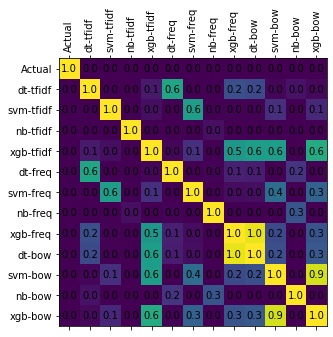

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.698630  0.662791    0.680710  0.631148
xgb-bow    0.702055  0.648256    0.675155  0.677049
xgb-tfidf  0.703196  0.610465    0.656831  0.540984
xgb-freq   0.686073  0.610465    0.648269  0.581148
svm-tfidf  0.809361  0.485465    0.647413  0.641803
dt-bow     0.690639  0.601744    0.646192  0.706557
svm-freq   0.796804  0.476744    0.636774  0.718033
nb-bow     0.560502  0.712209    0.636356  0.688525
dt-tfidf   0.670091  0.569767    0.619929  0.664754
dt-freq    0.664384  0.546512    0.605448  0.665574
nb-freq    0.550228  0.659884    0.605056  0.603279
nb-tfidf   0.498858  0.648256    0.573557  0.686885

Mean: 0.6639761560516578




Method: SMOTETomek

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


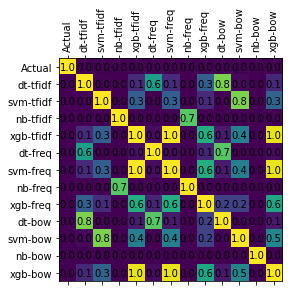

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.796804  0.561047    0.678925  0.714754
xgb-bow    0.778539  0.555233    0.666886  0.425410
svm-tfidf  0.828767  0.497093    0.662930  0.684426
svm-freq   0.787671  0.529070    0.658371  0.714754
xgb-tfidf  0.810502  0.470930    0.640716  0.735246
xgb-freq   0.788813  0.491279    0.640046  0.672951
dt-bow     0.738584  0.529070    0.633827  0.679508
dt-freq    0.768265  0.430233    0.599249  0.704918
dt-tfidf   0.803653  0.380814    0.592233  0.431967
nb-bow     0.464612  0.645349    0.554980  0.730328
nb-tfidf   0.289954  0.793605    0.541779  0.515574
nb-freq    0.284247  0.784884    0.534565  0.715574

Mean: 0.6465006003871885




Method: RandomOver

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


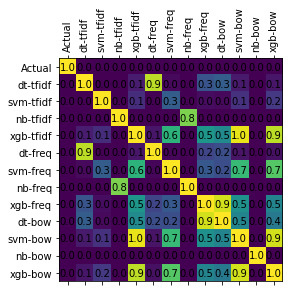

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.763699  0.578488    0.671094  0.698361
svm-tfidf  0.829909  0.511628    0.670768  0.676230
xgb-bow    0.777397  0.549419    0.663408  0.673770
svm-freq   0.804795  0.502907    0.653851  0.740164
dt-bow     0.759132  0.537791    0.648462  0.696721
xgb-tfidf  0.791096  0.505814    0.648455  0.441803
xgb-freq   0.785388  0.476744    0.631066  0.710656
nb-bow     0.563927  0.694767    0.629347  0.711475
dt-tfidf   0.772831  0.430233    0.601532  0.719672
dt-freq    0.769406  0.430233    0.599819  0.446721
nb-freq    0.305936  0.805233    0.555584  0.713115
nb-tfidf   0.311644  0.773256    0.542450  0.600820

Mean: 0.655064286356099




Method: ADASYN

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


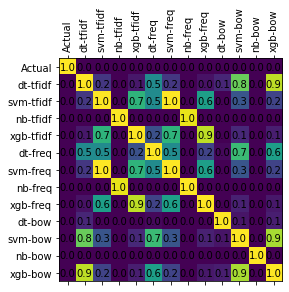

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-tfidf  0.736301  0.587209    0.661755  0.694262
svm-freq   0.746575  0.561047    0.653811  0.680328
svm-bow    0.703196  0.593023    0.648110  0.705738
xgb-freq   0.783105  0.508721    0.645913  0.415574
xgb-bow    0.704338  0.578488    0.641413  0.414754
xgb-tfidf  0.786530  0.491279    0.638904  0.694262
dt-bow     0.652968  0.587209    0.620089  0.634426
dt-tfidf   0.769406  0.404070    0.586738  0.703279
dt-freq    0.803653  0.366279    0.584966  0.666393
nb-bow     0.452055  0.642442    0.547248  0.672131
nb-tfidf   0.264840  0.799419    0.532129  0.668852
nb-freq    0.265982  0.793605    0.529793  0.505738

Mean: 0.637759248821689




Method: none

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


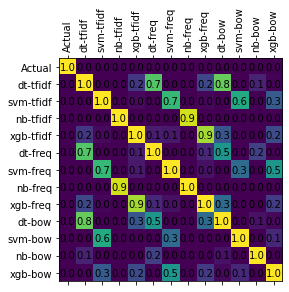

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.918950  0.415698    0.667324  0.474590
xgb-bow    0.871005  0.430233    0.650619  0.723770
nb-bow     0.704338  0.563953    0.634146  0.777049
svm-tfidf  0.940639  0.325581    0.633110  0.767213
dt-bow     0.810502  0.427326    0.618914  0.702459
xgb-tfidf  0.863014  0.369186    0.616100  0.690164
svm-freq   0.949772  0.273256    0.611514  0.696721
xgb-freq   0.863014  0.357558    0.610286  0.759016
dt-tfidf   0.825342  0.369186    0.597264  0.472951
dt-freq    0.820776  0.357558    0.589167  0.720492
nb-tfidf   0.361872  0.761628    0.561750  0.664754
nb-freq    0.359589  0.761628    0.560608  0.746721

Mean: 0.642369364733175




Method: aug

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


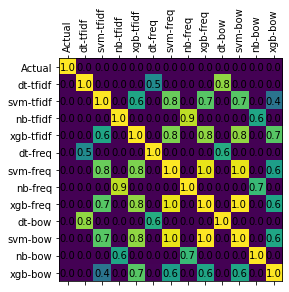

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
xgb-bow    0.750000  0.613372    0.681686  0.722951
svm-bow    0.780822  0.572674    0.676748  0.656557
svm-tfidf  0.815068  0.508721    0.661895  0.728689
xgb-freq   0.810502  0.497093    0.653798  0.456557
xgb-tfidf  0.807078  0.491279    0.649178  0.718033
svm-freq   0.828767  0.453488    0.641128  0.642623
dt-bow     0.681507  0.558140    0.619823  0.646721
dt-freq    0.719178  0.497093    0.608136  0.459016
dt-tfidf   0.695205  0.508721    0.601963  0.722131
nb-freq    0.305936  0.848837    0.577387  0.467213
nb-tfidf   0.304795  0.843023    0.573909  0.711475
nb-bow     0.341324  0.787791    0.564557  0.722131

Mean: 0.6546313540977446




Overall scores:
Friedman Chi Square Statistic: 25.476190476190524. p-value: 0.00011272298057656395.
           RandomUnder  SMOTETomek  RandomOver    ADASYN      none       aug
Actual        1.000000    1.000000    1.000000  1.000000  1.00000

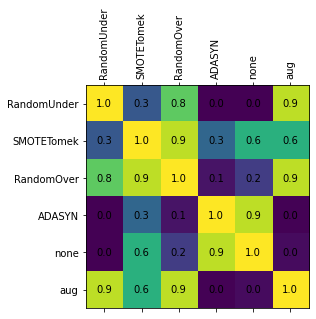

In [12]:
task_eval('binary')


Task: 5Type


Method: RandomUnder

Task: 5type.
Cochran's Q test p-value: 1.467281451377e-311
Post-hoc Dunn test array:


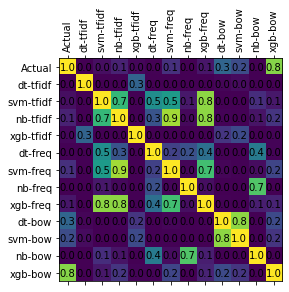

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
svm-bow    0.336758  0.464706    0.250  0.595238  0.201613    0.369663   
xgb-bow    0.320776  0.364706    0.250  0.333333  0.274194    0.308602   
svm-freq   0.299087  0.341176    0.125  0.547619  0.161290    0.294835   
dt-bow     0.396119  0.247059    0.250  0.357143  0.120968    0.274258   
nb-bow     0.253425  0.329412    0.250  0.380952  0.153226    0.273403   
xgb-tfidf  0.420091  0.282353    0.125  0.357143  0.177419    0.272401   
xgb-freq   0.305936  0.276471    0.250  0.333333  0.193548    0.271858   
dt-tfidf   0.440639  0.317647    0.125  0.190476  0.225806    0.259914   
dt-freq    0.277397  0.305882    0.250  0.190476  0.233871    0.251525   
nb-tfidf   0.300228  0.317647    0.125  0.190476  0.274194    0.241509   
nb-freq    0.245434  0.300000    0.125  0.238095  0.241935    0.230093   
svm-tfidf  0.307078  0.276471    0.000

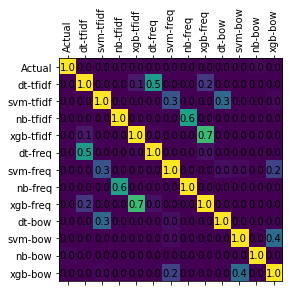

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
svm-freq   0.496575  0.470588    0.000  0.404762  0.193548    0.313095   
xgb-freq   0.750000  0.358824    0.000  0.214286  0.145161    0.293654   
svm-tfidf  0.473744  0.429412    0.000  0.333333  0.209677    0.289233   
xgb-bow    0.544521  0.435294    0.000  0.214286  0.225806    0.283981   
xgb-tfidf  0.764840  0.347059    0.000  0.142857  0.161290    0.283209   
dt-bow     0.439498  0.435294    0.000  0.261905  0.274194    0.282178   
svm-bow    0.585616  0.394118    0.000  0.119048  0.209677    0.261692   
nb-tfidf   0.141553  0.347059    0.250  0.380952  0.185484    0.261010   
dt-tfidf   0.731735  0.276471    0.000  0.119048  0.137097    0.252870   
dt-freq    0.716895  0.270588    0.000  0.119048  0.129032    0.247113   
nb-bow     0.308219  0.341176    0.125  0.309524  0.145161    0.245816   
nb-freq    0.146119  0.247059    0.250

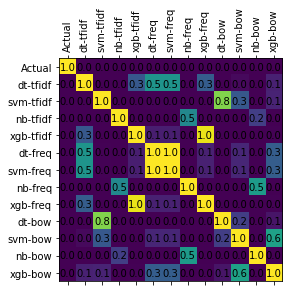

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
xgb-bow    0.615297  0.388235    0.375  0.357143  0.145161    0.376167   
svm-freq   0.623288  0.511765    0.000  0.428571  0.129032    0.338531   
dt-bow     0.561644  0.417647    0.250  0.309524  0.129032    0.333569   
svm-tfidf  0.565068  0.370588    0.000  0.500000  0.169355    0.321002   
svm-bow    0.606164  0.411765    0.250  0.190476  0.129032    0.317488   
nb-bow     0.074201  0.317647    0.375  0.547619  0.241935    0.311281   
xgb-tfidf  0.710046  0.329412    0.000  0.119048  0.217742    0.275249   
xgb-freq   0.710046  0.341176    0.000  0.095238  0.201613    0.269615   
nb-tfidf   0.122146  0.323529    0.250  0.428571  0.209677    0.266785   
dt-tfidf   0.689498  0.317647    0.000  0.119048  0.161290    0.257497   
nb-freq    0.113014  0.276471    0.250  0.404762  0.201613    0.249172   
dt-freq    0.675799  0.300000    0.000

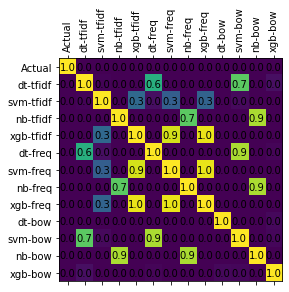

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
nb-bow     0.089041  0.311765    0.125  0.785714  0.266129    0.315530   
svm-freq   0.925799  0.188235    0.250  0.000000  0.000000    0.272807   
svm-tfidf  0.894977  0.158824    0.250  0.000000  0.048387    0.270438   
nb-tfidf   0.117580  0.347059    0.250  0.404762  0.169355    0.257751   
nb-freq    0.115297  0.294118    0.250  0.428571  0.185484    0.254694   
xgb-tfidf  0.900685  0.258824    0.000  0.000000  0.080645    0.248031   
xgb-freq   0.905251  0.247059    0.000  0.000000  0.072581    0.244978   
svm-bow    0.803653  0.335294    0.000  0.000000  0.016129    0.231015   
xgb-bow    0.735160  0.311765    0.000  0.071429  0.032258    0.230122   
dt-freq    0.820776  0.205882    0.000  0.023810  0.096774    0.229448   
dt-tfidf   0.808219  0.211765    0.000  0.023810  0.080645    0.224888   
dt-bow     0.672374  0.264706    0.000

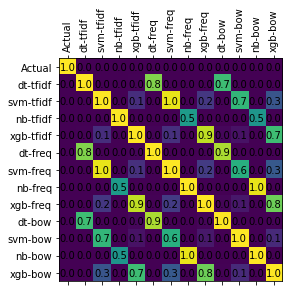

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
nb-bow     0.090183  0.305882    0.375  0.547619  0.241935    0.312124   
dt-bow     0.816210  0.370588    0.000  0.142857  0.064516    0.278834   
xgb-bow    0.898402  0.400000    0.000  0.047619  0.040323    0.277269   
svm-bow    0.942922  0.435294    0.000  0.000000  0.008065    0.277256   
svm-tfidf  0.948630  0.317647    0.000  0.000000  0.040323    0.261320   
xgb-freq   0.906393  0.294118    0.000  0.000000  0.088710    0.257844   
nb-tfidf   0.118721  0.352941    0.250  0.404762  0.161290    0.257543   
xgb-tfidf  0.904110  0.282353    0.000  0.000000  0.096774    0.256647   
dt-freq    0.829909  0.258824    0.000  0.023810  0.129032    0.248315   
nb-freq    0.115297  0.270588    0.250  0.428571  0.169355    0.246762   
svm-freq   0.962329  0.270588    0.000  0.000000  0.000000    0.246583   
dt-tfidf   0.824201  0.270588    0.000

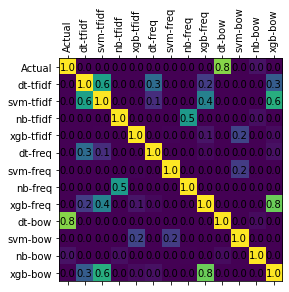

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
dt-tfidf   0.458904  0.411765    0.500  0.380952  0.282258    0.406776   
dt-freq    0.432648  0.423529    0.375  0.523810  0.225806    0.396159   
xgb-tfidf  0.543379  0.435294    0.125  0.500000  0.282258    0.377186   
xgb-bow    0.474886  0.411765    0.125  0.428571  0.387097    0.365464   
svm-bow    0.574201  0.452941    0.125  0.309524  0.354839    0.363301   
dt-bow     0.351598  0.311765    0.375  0.380952  0.322581    0.348379   
xgb-freq   0.505708  0.382353    0.125  0.380952  0.282258    0.335254   
svm-tfidf  0.517123  0.241176    0.250  0.404762  0.225806    0.327774   
nb-bow     0.280822  0.347059    0.250  0.404762  0.338710    0.324270   
svm-freq   0.655251  0.347059    0.000  0.333333  0.193548    0.305838   
nb-tfidf   0.235160  0.394118    0.125  0.333333  0.217742    0.261071   
nb-freq    0.220320  0.364706    0.125

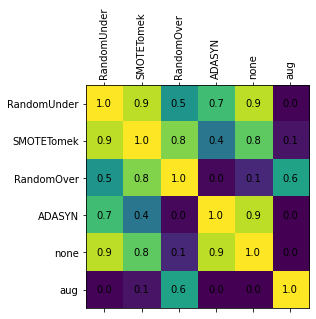

In [13]:
task_eval('5type')


Task: 4Type


Method: RandomUnder

Task: 4type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


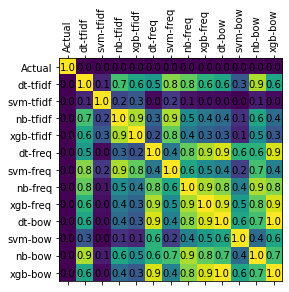

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.447059    0.500  0.461538  0.170732    0.394832  0.329412
dt-freq    0.364706    0.375  0.487179  0.292683    0.379892  0.350000
nb-bow     0.417647    0.500  0.410256  0.186992    0.378724  0.320588
svm-bow    0.441176    0.250  0.461538  0.252033    0.351187  0.267647
xgb-freq   0.352941    0.250  0.435897  0.317073    0.338978  0.370588
svm-freq   0.347059    0.125  0.641026  0.195122    0.327052  0.335294
dt-tfidf   0.429412    0.375  0.230769  0.219512    0.313673  0.314706
xgb-bow    0.417647    0.125  0.461538  0.235772    0.309989  0.341176
nb-tfidf   0.370588    0.250  0.333333  0.235772    0.297423  0.347059
nb-freq    0.417647    0.125  0.410256  0.227642    0.295136  0.352941
svm-tfidf  0.282353    0.000  0.538462  0.178862    0.249919  0.350000
xgb-tfidf  0.417647    0.000  0.282051  0.186992    0.221673  0.308824

Mean:

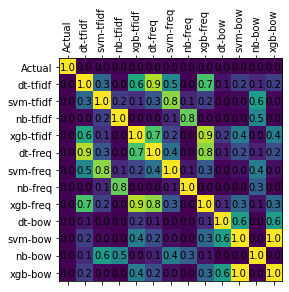

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.500000    0.500  0.641026  0.121951    0.440744  0.494118
dt-bow     0.611765    0.125  0.538462  0.406504    0.420433  0.441176
xgb-bow    0.552941    0.125  0.538462  0.422764    0.409792  0.338235
svm-bow    0.594118    0.125  0.384615  0.414634    0.379592  0.402941
svm-tfidf  0.488235    0.000  0.846154  0.170732    0.376280  0.494118
xgb-tfidf  0.558824    0.000  0.512821  0.341463    0.353277  0.447059
svm-freq   0.494118    0.000  0.666667  0.243902    0.351172  0.379412
dt-freq    0.570588    0.000  0.487179  0.292683    0.337613  0.350000
xgb-freq   0.558824    0.000  0.435897  0.349593    0.336079  0.411765
dt-tfidf   0.564706    0.000  0.461538  0.292683    0.329732  0.461765
nb-tfidf   0.529412    0.375  0.256410  0.130081    0.322726  0.455882
nb-freq    0.529412    0.375  0.256410  0.097561    0.314596  0.517647

Mean:

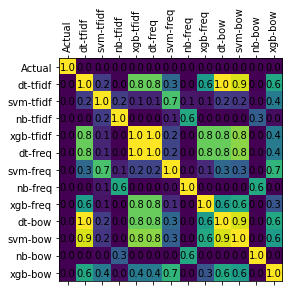

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.570588    0.250  0.615385  0.235772    0.417936  0.394118
svm-bow    0.588235    0.125  0.692308  0.203252    0.402199  0.447059
svm-freq   0.505882    0.125  0.717949  0.195122    0.385988  0.447059
svm-tfidf  0.447059    0.000  0.846154  0.203252    0.374116  0.426471
xgb-bow    0.552941    0.125  0.589744  0.219512    0.371799  0.458824
xgb-freq   0.547059    0.000  0.487179  0.390244    0.356121  0.408824
dt-freq    0.535294    0.000  0.487179  0.373984    0.349114  0.320588
nb-bow     0.452941    0.500  0.282051  0.081301    0.329073  0.300000
nb-tfidf   0.517647    0.375  0.307692  0.105691    0.326508  0.470588
xgb-tfidf  0.558824    0.000  0.358974  0.382114    0.324978  0.341176
dt-tfidf   0.552941    0.000  0.358974  0.357724    0.317410  0.458824
nb-freq    0.494118    0.375  0.256410  0.097561    0.305772  0.450000

Mean:

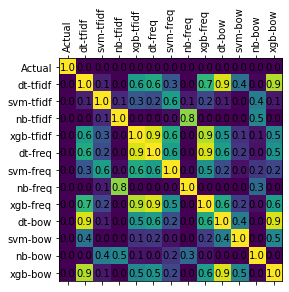

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.476471    0.500  0.794872  0.113821    0.471291  0.488235
xgb-bow    0.647059    0.125  0.230769  0.373984    0.344203  0.458824
dt-bow     0.682353    0.125  0.256410  0.308943    0.343177  0.352941
nb-tfidf   0.529412    0.375  0.307692  0.121951    0.333514  0.517647
nb-freq    0.529412    0.375  0.307692  0.097561    0.327416  0.382353
svm-bow    0.735294    0.125  0.025641  0.398374    0.321077  0.482353
dt-tfidf   0.682353    0.000  0.282051  0.300813    0.316304  0.414706
dt-freq    0.623529    0.000  0.307692  0.317073    0.312074  0.464706
xgb-freq   0.635294    0.000  0.230769  0.333333    0.299849  0.344118
xgb-tfidf  0.641176    0.000  0.153846  0.333333    0.282089  0.461765
svm-freq   0.635294    0.000  0.000000  0.333333    0.242157  0.438235
svm-tfidf  0.552941    0.000  0.000000  0.382114    0.233764  0.485294

Mean:

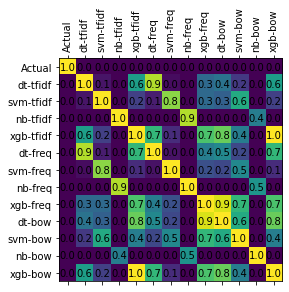

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.711765    0.125  0.333333  0.325203    0.373825  0.502941
nb-bow     0.458824    0.500  0.307692  0.105691    0.343052  0.502941
xgb-freq   0.700000    0.000  0.256410  0.382114    0.334631  0.485294
xgb-bow    0.670588    0.000  0.282051  0.373984    0.331656  0.514706
nb-tfidf   0.517647    0.375  0.307692  0.121951    0.330573  0.314706
xgb-tfidf  0.682353    0.000  0.256410  0.365854    0.326154  0.341176
nb-freq    0.523529    0.375  0.307692  0.097561    0.325946  0.535294
svm-freq   0.829412    0.000  0.000000  0.414634    0.311011  0.479412
dt-freq    0.688235    0.000  0.230769  0.317073    0.309019  0.564706
svm-tfidf  0.800000    0.000  0.000000  0.430894    0.307724  0.555882
dt-tfidf   0.670588    0.000  0.230769  0.325203    0.306640  0.517647
svm-bow    0.758824    0.000  0.025641  0.422764    0.301807  0.347059

Mean:

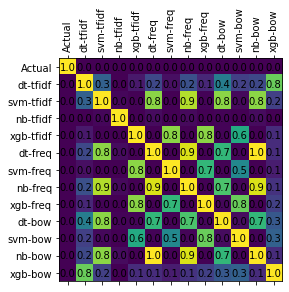

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
xgb-freq   0.641176    0.500  0.487179  0.495935    0.531073  0.364706
dt-tfidf   0.529412    0.500  0.538462  0.455285    0.505789  0.455882
dt-freq    0.458824    0.500  0.666667  0.373984    0.499868  0.470588
xgb-tfidf  0.605882    0.250  0.512821  0.577236    0.486485  0.576471
xgb-bow    0.588235    0.500  0.410256  0.447154    0.486412  0.452941
svm-freq   0.735294    0.000  0.641026  0.398374    0.443673  0.502941
dt-bow     0.505882    0.375  0.435897  0.439024    0.438951  0.567647
svm-bow    0.694118    0.250  0.333333  0.455285    0.433184  0.461765
svm-tfidf  0.452941    0.000  0.615385  0.455285    0.380903  0.555882
nb-bow     0.452941    0.125  0.461538  0.471545    0.377756  0.452941
nb-freq    0.535294    0.000  0.564103  0.341463    0.360215  0.585294
nb-tfidf   0.400000    0.000  0.358974  0.341463    0.275109  0.514706

Mean:

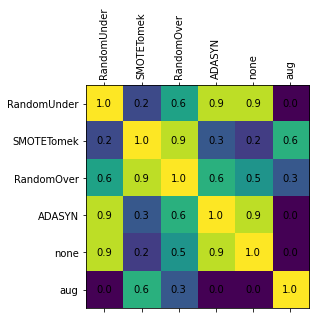

In [14]:
task_eval('4type')

In [15]:
def compare_aug(method):
    for task in ['binary', '5type', '4type']:
        df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
        aug_df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-aug.csv')
        df['Common'] = df.apply(lambda x: mode(np.array(x, dtype=np.int64)), axis=1)
        aug_df['Common'] = aug_df.apply(lambda x: mode(np.array(x, dtype=np.int64)), axis=1)
        result = cochrans_q([df['Common'], aug_df['Common']])
        
        #get row with int correct/incorrect
        aug_columns = list(aug_df.columns.values)
        common, actual = aug_columns.index('Common'), aug_columns.index('Actual')
        aug_df["Correct"] = aug_df.apply(lambda x: int(x[common] == x[actual]), axis=1)
        columns = list(df.columns.values)
        common, actual = columns.index('Common'), columns.index('Actual')
        df["Correct"] = df.apply(lambda x: int(x[common] == x[actual]), axis=1)
        
        print(f'Task: {task}')
        print(f"McNemar's test p-value: {result.pvalue}\n")
        print(f'Augmented mean accuracy: {aug_df["Correct"].mean()}.\nOriginal mean accuracy: {df["Correct"].mean()}.')
        print('\n')

In [16]:
compare_aug('RandomUnder')

Task: binary
McNemar's test p-value: 2.638098295064013e-26

Augmented mean accuracy: 0.7540983606557377.
Original mean accuracy: 0.7221311475409836.


Task: 5type
McNemar's test p-value: 1.4041214053653574e-06

Augmented mean accuracy: 0.6.
Original mean accuracy: 0.48114754098360657.


Task: 4type
McNemar's test p-value: 0.10489919394115725

Augmented mean accuracy: 0.6705882352941176.
Original mean accuracy: 0.4588235294117647.


